In [1]:
import pickle as p

In [2]:
(t, co2_ts, co2_pred, co2_erfc_pred, b) = p.load(open('results/ec_time_series.p', 'rb'))
(my_network, my_time_series) = p.load(open('data/GPSData.p', 'rb'))

HSL_EC = (-119.021559, 37.613324)
strain_calculator = my_network.get_strain_calculator([0.005, 0.005], strain_method='gpsgridder', strain_range=[HSL_EC[0]-0.005,HSL_EC[0]+0.0051,HSL_EC[1]-0.005,HSL_EC[1]+0.005])

In [3]:
import matplotlib.pylab as plt
from matplotlib.gridspec import GridSpec
from plotting import plot_dilatation
from gpsutils import strain_from_network_for_date
import numpy as np

In [4]:
def calculate_stresses(E, nu, azimuth, date):
    lons, lats, rot, exx, exy, eyy = strain_from_network_for_date(strain_calculator, my_time_series, np.datetime64(date))
    e = np.array([[exx[1,1], exy[1,1]],[exy[1,1], eyy[1,1]]])
    s = E / (1-np.power(nu,2)) * ((1 - nu)*e + nu*np.trace(e)*np.identity(2))
    strike_v = np.array([np.cos(np.deg2rad(90.0-azimuth)), np.sin(np.deg2rad(90-azimuth)), 0])
    vertical = np.array([0, 0, 1])
    n = np.cross(strike_v, vertical)[0:2]
    strike_v = strike_v[0:2]
    return np.matmul(np.matmul(n.T,s),n), np.matmul(np.matmul(strike_v.T,s),strike_v)
    


In [5]:
from datetime import datetime
from utils import daterange

min_t = datetime(2014, 7, 22)
max_t = datetime(2020, 5, 24)

E = 200E9
nu = 0.3
azimuth = -45.0

n, s = [], []
for time in daterange(min_t, max_t):
    normal, shear = calculate_stresses(E, nu, -45.0, time)
    n += [normal]
    s += [shear]
n, s = np.array(n), np.array(s)
            

In [6]:
def gaussian_filter(time, data):
    
    time_decimal_day = (time - np.min(time)).astype('timedelta64[s]').astype(np.float64) / (60.0*60.0*24.0)
        
    def inner_function(wavelength_in_days):
        
        def calculate_values(t0):
            tn = (time_decimal_day - t0) / wavelength_in_days
            i = np.where(np.logical_and(tn > -5, tn < 5))
            weights = np.exp(-0.5*np.power(tn[i],2))
            weights /= np.sum(weights)
            return np.sum(data[i]*weights)
    
        return np.vectorize(calculate_values)(time_decimal_day)
    
    return inner_function

In [7]:
my_filter = gaussian_filter(t, co2_ts)
co2_ts_smoothed = my_filter(30.0)

In [8]:
t_stress = np.array(list(daterange(min_t, max_t))).astype(np.datetime64)
_, t_index, t_stress_index = np.intersect1d(t, t_stress, assume_unique=False, return_indices=True)
t_stress_year = np.array([datetime(dt.year,1,1) for dt in daterange(min_t, max_t)]).astype(np.datetime64)


In [9]:
t_year = np.array([datetime(ti.astype(object).year, 1,1) for ti in t]).astype(np.datetime64)

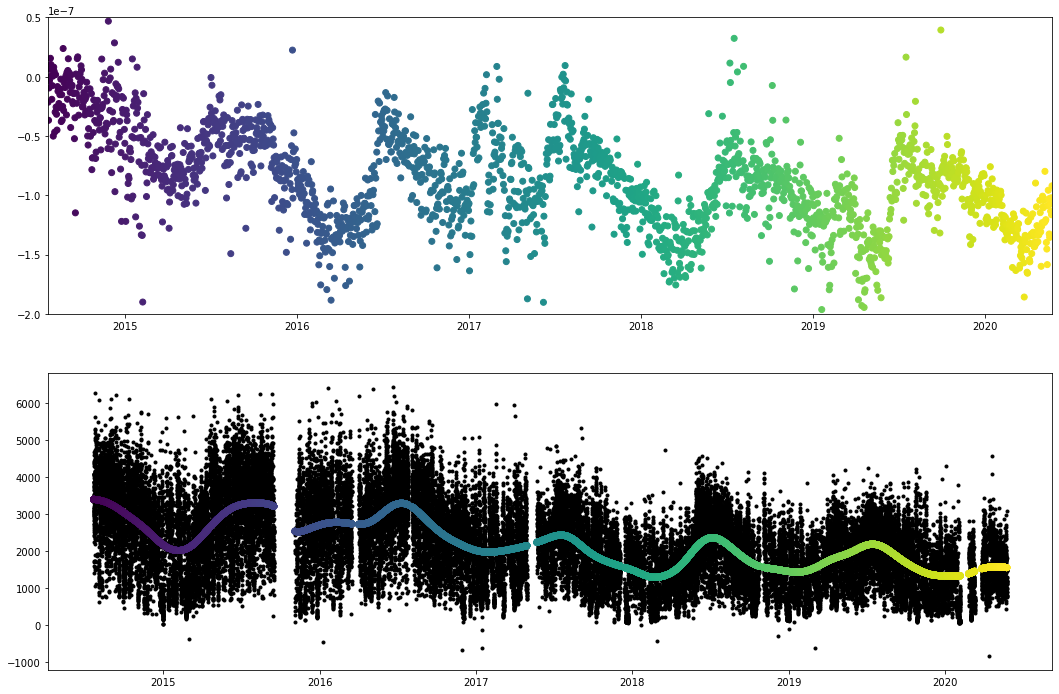

In [10]:
fig = plt.figure()
fig.set_size_inches(18, 12)
gs = GridSpec(2, 1, height_ratios=[2, 2])
ax1 = fig.add_subplot(2,1,1)
ax2 = fig.add_subplot(2,1,2)
plt.sca(ax1)
plt.scatter(t_stress, n / E, c=t_stress, zorder = 1)
plt.axis([min_t, max_t, -2E-7, 0.5E-7])
plt.sca(ax2)
plt.plot(t, co2_ts,'k.', zorder = -1)
plt.scatter(t, co2_ts_smoothed,c = t, zorder = 1)
ax1.set_position(gs[0].get_position(fig))
ax2.set_position(gs[1].get_position(fig))
ax1.set_anchor("W")
ax2.set_anchor("W")

(-2e-07, 5e-08, 1000.0, 3500.0)

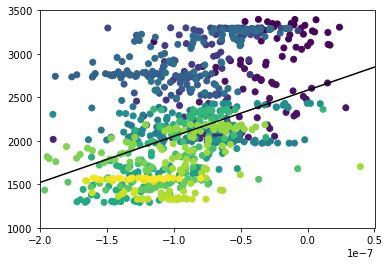

In [11]:
plt.scatter(n[t_stress_index] / E, co2_ts_smoothed[t_index], c=t[t_stress_index])


from scipy import stats

slope, intercept, r_value, p_value, std_err = stats.linregress(n[t_stress_index] / E,co2_ts_smoothed[t_index])
plt.plot([-2E-7, 0.5E-7], [slope*-2E-7+intercept, slope*0.5E-10+intercept], 'k-')
plt.axis([-2E-7, 0.5E-7, 1000, 3500])


In [12]:
print('r_value: ', r_value)
print('p_value: ', p_value)

r_value:  0.46611438048009557
p_value:  1.2248757174772557e-46


In [13]:
A1s1 = 1000.0
A2s1 = 500
wl1 = 0.5

A1s2 = 1000.0
A2s2 = 500
wl2 = 1.0

A1s3 = 2000.0
A2s3 = 0
wl3 = 365.0

Aerfc = 1000.0
tc = 600.0
tstar = 10.0

b = 3000.0

def periodic_signal(t, wl):
    
    t_days = (t-min(t)).astype('timedelta64[s]').astype(np.float64)/(60.0*60.0*24.0)
    
    def inner_function(A1, A2):
        return A1 * np.cos(2.0*np.pi*t_days/wl) + A2 * np.sin(2.0*np.pi*t_days/wl)
    
    return inner_function

from scipy.special import erf

def erfc_signal(t):
    
    t_days = (t-min(t)).astype('timedelta64[s]').astype(np.float64)/(60.0*60.0*24.0)
    
    def inner_function(A, tc, tstar):
        return A*(1 - erf((t_days - tc) / tstar))
    
    return inner_function

def total_signal(t, wl1, wl2, wl3):
    
    periodic1 = periodic_signal(t, wl1)
    periodic2 = periodic_signal(t, wl2)
    periodic3 = periodic_signal(t, wl3)
    
    erfc = erfc_signal(t)
    
    def inner_function(x):
        (A1s1, A2s1, A1s2, A2s2, A1s3, A2s3, Aerfc, tc, tstar, b) = x
        return periodic1(A1s1, A2s1) + periodic2(A1s2, A2s2) + periodic3(A1s3, A2s3) + erfc(Aerfc, tc, tstar) + b
    
    return inner_function

def model_misfit(t, co2_flux_obs, wl1, wl2, wl3):
    
    model = total_signal(t, wl1, wl2, wl3)
    
    def inner_function(x):
        return np.sum(np.power(model(x) - co2_flux_obs, 2))
    
    return inner_function

x0 = (A1s1, A2s1, A1s2, A2s2, A1s3, A2s3, Aerfc, tc, tstar, b)

from scipy.optimize import fmin

optimize_function = model_misfit(t, co2_ts, wl1, wl2, wl3)
x = fmin(optimize_function, x0, maxfun = 1E12)

(A1s1, A2s1, A1s2, A2s2, A1s3, A2s3, Aerfc, tc, tstar, b) = x

model = total_signal(t, wl1, wl2, wl3)

Optimization terminated successfully.
         Current function value: 33151250827.865566
         Iterations: 2682
         Function evaluations: 3816


<ipython-input-15-08aa3e1b42e0>:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(np.round_(plt.gca().get_yticks(),2), fontdict = {"family": "Arial Rounded MT Bold", "size": 10})
<ipython-input-15-08aa3e1b42e0>:31: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(plt.gca().get_xticks(), fontdict = {"family": "Arial Rounded MT Bold", "size": 10})
<ipython-input-15-08aa3e1b42e0>:41: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(np.round_(plt.gca().get_yticks(),2), fontdict = {"family": "Arial Rounded MT Bold", "size": 10})
<ipython-input-15-08aa3e1b42e0>:42: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(plt.gca().get_xticks(), fontdict = {"family": "Arial Rounded MT Bold", "size": 10})


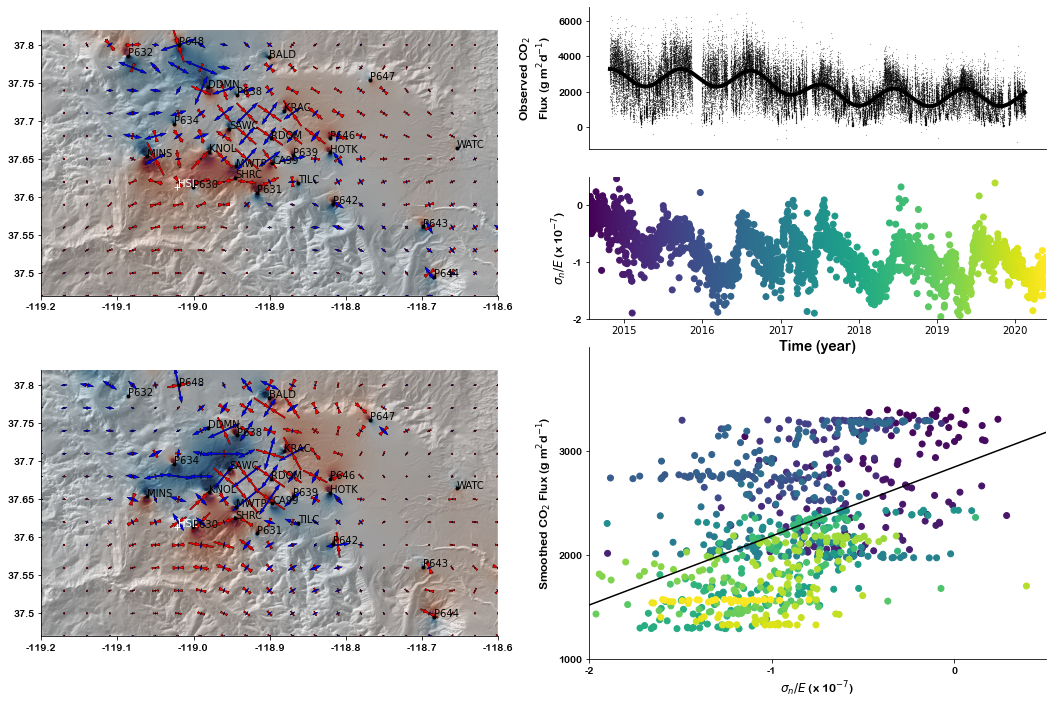

In [15]:
from datetime import datetime

strain_calculator = my_network.get_strain_calculator([0.001, 0.001], strain_method='gpsgridder', strain_range=[-119.2,-118.6,37.47,37.82])

fig = plt.figure()
fig.set_size_inches(18, 12)

gs = GridSpec(4, 2)
ax1 = fig.add_subplot(gs[0:2, 0])
ax2 = fig.add_subplot(gs[2:, 0])
ax3 = fig.add_subplot(gs[0, 1])
ax4 = fig.add_subplot(gs[1,1])
ax5 = fig.add_subplot(gs[2:, 1])

fig.patch.set_alpha(0.0)
ax1.patch.set_alpha(0.0)
ax2.patch.set_alpha(0.0)
ax3.patch.set_alpha(0.0)
ax4.patch.set_alpha(0.0)
ax5.patch.set_alpha(0.0)

plt.sca(ax1)

date = datetime(2018, 1, 21)
[lons, lats, rot_grd, exx_grd, exy_grd, eyy_grd] = strain_from_network_for_date(strain_calculator, my_time_series, np.datetime64(date), field_prefix = 'filtered')
plot_dilatation(lons, lats, exx_grd*1E9, exy_grd*1E9, eyy_grd*1E9, strain_calculator.strain_range, width=2000, eigs_dec = 30, do_not_print_value = 400.0, overmax_scale = 400.0, scale = 1E-4, colorbar = False)
my_network.plot(axis = [-119.2,-118.6,37.47,37.82])
plt.axis('scaled')
plt.axis([-119.2,-118.6,37.47,37.82])
plt.gca().set_yticklabels(np.round_(plt.gca().get_yticks(),2), fontdict = {"family": "Arial Rounded MT Bold", "size": 10})
plt.gca().set_xticklabels(plt.gca().get_xticks(), fontdict = {"family": "Arial Rounded MT Bold", "size": 10})

plt.sca(ax2)

date = datetime(2018, 7, 21)
[lons, lats, rot_grd, exx_grd, exy_grd, eyy_grd] = strain_from_network_for_date(strain_calculator, my_time_series, np.datetime64(date), field_prefix = 'filtered')
plot_dilatation(lons, lats, exx_grd*1.0E9, exy_grd*1.0E9, eyy_grd*1.0E9, strain_calculator.strain_range, width=2000, eigs_dec = 30, do_not_print_value = 400.0, overmax_scale = 400.0, scale = 1E-4, colorbar = False)
my_network.plot(axis = [-119.2,-118.6,37.47,37.82])
plt.axis('scaled')
plt.axis([-119.2,-118.6,37.47,37.82])
plt.gca().set_yticklabels(np.round_(plt.gca().get_yticks(),2), fontdict = {"family": "Arial Rounded MT Bold", "size": 10})
plt.gca().set_xticklabels(plt.gca().get_xticks(), fontdict = {"family": "Arial Rounded MT Bold", "size": 10})

plt.sca(ax3)

x_nodiurnal = (0.0, 0.0, 0.0, 0.0, A1s3, A2s3, Aerfc, tc, tstar, 0.0)
co2_nodiurnal = model(x_nodiurnal)

plt.plot(t, co2_ts,'k.', markersize = 0.25)
plt.plot(t, co2_nodiurnal + b, 'k-', linewidth = 4)
plt.yticks(np.arange(0, 8000, 2000))
plt.gca().set_yticklabels(plt.gca().get_yticks(), fontdict = {"family": "Arial Rounded MT Bold", "size": 10})
plt.ylabel('Observed CO$_{2}$ \nFlux (g m$^{2}$d$^{-1}$)', fontname = "Arial Rounded MT Bold", fontsize = 12)
plt.gca().get_xaxis().set_visible(False)
plt.gca().axis('tight')

plt.sca(ax4)
plt.scatter(t_stress, (n / E) * 1E7, c=t_stress)
plt.axis([min_t, max_t, -2, 0.5])
plt.xlabel('Time (year)', fontname = "Arial Rounded MT Bold", fontsize = 14)
plt.yticks(np.arange(-2, 1, 1))
plt.gca().set_yticklabels(np.round_(plt.gca().get_yticks(),0), fontdict = {"family": "Arial Rounded MT Bold", "size": 10})
plt.ylabel('$\sigma_{n} / E$ (x 10$^{-7}$)', fontname = "Arial Rounded MT Bold", fontsize = 12)

plt.sca(ax5)
plt.scatter((n[t_stress_index] / E) * 1E7, co2_ts_smoothed[t_index], c=t[t_index], zorder=2)
from scipy import stats
slope, intercept, r_value, p_value, std_err = stats.linregress((n[t_stress_index] / E) * 1E7, co2_ts_smoothed[t_index])
plt.plot([-2, 0.5], [slope*-2+intercept, slope*0.5+intercept], 'k-')
plt.axis([-2, 0.5, 1000, 4000])
plt.xlabel('$\sigma_{n} / E$ (x 10$^{-7}$)', fontname = "Arial Rounded MT Bold", fontsize = 12)
plt.ylabel('Smoothed CO$_{2}$ Flux (g m$^{2}$d$^{-1}$)', fontname = "Arial Rounded MT Bold", fontsize = 12)
plt.xticks(np.arange(-2, 1, 1))
plt.gca().set_xticklabels(np.round_(plt.gca().get_xticks(),0), fontdict = {"family": "Arial Rounded MT Bold", "size": 10})
plt.yticks(np.arange(1000, 4000, 1000))
plt.gca().set_yticklabels(plt.gca().get_yticks(), fontdict = {"family": "Arial Rounded MT Bold", "size": 10})

plt.rc('axes.spines', **{'bottom':True, 'left':True, 'right':False, 'top':False})

plt.savefig('results/FigureS2.eps', format = 'eps')